# Data prep and modeling

The first half of this notebook is basically converting the dictionary of dataframes built in the timeline notebook into train, val, and test sets consisting of tensors of timeframes as their features and tensors of positions as their targets.

The second half is building models (and a custon loss function) and then evaluating them.

Some of the tools here are based on the tensorflow guide on time series - though they were heavily modified.
https://www.tensorflow.org/tutorials/structured_data/time_series/

In [1]:
import pickle
import json
import requests
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
np.random.seed(4)

# these are from the keras guide
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## preparing the data a bit

In [3]:
# load the game-dataframe dictionary
dfs_dict = pickle.load(open("../data/timeline-di.p", "rb"))

In [4]:
# Here I split the dataframe by game. If using the model to predict future clid games, the ids shouldn't be shuffled.
gameids = list(dfs_dict.keys())
np.random.shuffle(gameids)
idcount = len(gameids)
# these can be changed if different sized splits are wanted
# (or remove older games if ids are sorted)
splits = [int(idcount*i) for i in [0,.8,.9,1]]
train_ids = gameids[splits[0]:splits[1]]
val_ids = gameids[splits[1]:splits[2]]
test_ids = gameids[splits[2]:splits[3]]

In [5]:
# Checking things are working
dfs_dict[train_ids[1]][0:10]

,enemy6currentGold,enemy6totalGold,enemy6level,enemy6jungleMinionsKilled,enemy6x,enemy6y,enemy7currentGold,enemy7totalGold,enemy7level,enemy7jungleMinionsKilled,...,ally4jungleMinionsKilled,ally4x,ally4y,ally_side,playercurrentGold,playertotalGold,playerlevel,playerjungleMinionsKilled,playerx,playery
0,500.0,500.0,1.0,0.0,351.0,293.0,500.0,500.0,1.0,0.0,...,0.0,14237.0,14579.0,1,500,500,1,0,14486,14291
1,0.0,500.0,1.0,0.0,6882.0,6193.0,0.0,500.0,1.0,0.0,...,0.0,8509.0,5793.0,1,0,500,1,0,6898,8118
2,83.0,583.0,1.0,0.0,6210.0,6515.0,97.0,597.0,1.0,0.0,...,0.0,13097.0,2406.0,1,120,620,2,4,11453,6775
3,678.0,1178.0,3.0,0.0,8081.0,6800.0,427.0,927.0,3.0,0.0,...,0.0,14340.0,14391.0,1,579,1079,3,12,12431,2627
4,79.0,1364.0,3.0,0.0,5373.0,5570.0,662.0,1162.0,4.0,0.0,...,0.0,13769.0,4030.0,1,758,1258,3,13,10996,8668
5,411.0,1696.0,5.0,0.0,7192.0,7922.0,50.0,1550.0,5.0,0.0,...,0.0,13341.0,2434.0,1,1152,1652,4,23,6601,12746
6,60.0,2095.0,5.0,0.0,2838.0,2296.0,114.0,1764.0,5.0,0.0,...,0.0,12671.0,2094.0,1,37,1962,4,24,13522,7877
7,301.0,2336.0,6.0,0.0,6808.0,7439.0,609.0,2259.0,6.0,4.0,...,0.0,12705.0,3059.0,1,280,2205,5,29,11064,8619
8,625.0,2660.0,7.0,0.0,8198.0,6693.0,899.0,2549.0,7.0,4.0,...,0.0,12988.0,3607.0,1,657,2582,6,40,7533,8352
9,218.0,2953.0,7.0,0.0,6421.0,6660.0,427.0,2877.0,7.0,4.0,...,0.0,12922.0,2098.0,1,801,2726,6,40,12571,6306


In [6]:
# test cases that aren't used much anymore
test0 = dfs_dict[train_ids[0]][0:20]
test1 = dfs_dict[train_ids[1]][0:20]
column_indices = {name: i for i, name in enumerate(test0.columns)}

## Starting to make classes and functions

In [7]:
class WindowGenerator():
    """
    This class is heavily based on the tensorflow guide. It allows you
    to create windows from a dataset. Currently a different one needs
    to be called for each window shape, which isn't ideal but is 
    complicated to improve.
    
        Arguments:
    input_width: int of how many time steps back the feature set should
                 include.
                 
    label_width: int of how many time steps the label set should
                 include. This is always 1 for windows meant for models,
                 but windows made for plotting have larger values.
                 
    shift:       Always should be 1 as far as I can tell, indicates
                 how far into the future to predict. 
                 
    eg_df:       Basically just used to get column names but ideally
                 should be removed.
    
    dfdi:        Dictionary of game dataframes, with gameids as index
    
    label_columns: List of the columns of the dfs which are the target.
    
    train_ids, val_ids, and test_ids: Lists of game ids determined earlier.
    
    
    
    """
    def __init__(self, input_width, label_width, shift,
                 eg_df=test0, val_df = test1,
                 dfdi=dfs_dict,
                 train_ids=train_ids,
                 val_ids=val_ids,
                 test_ids=test_ids,
                 label_columns=None):
        
        # Store the dfs etc in the class.
        self.eg_df = eg_df
        self.val_df = val_df
        self.dfdi = dfdi
        
        self.train_ids = train_ids
        self.val_ids = val_ids
        self.test_ids = test_ids
        
        self.trainli = None
        self.valli = None
        self.testli = None

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(eg_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])

In [8]:
def split_window(self, features):
    """
    Splits window into labels and features.
    
    features: The full data being split. (tensor format I think)
    
    """
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        # Stacking the two labels because there's x and y!
        labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
    
    
    # Guide says this, not exactly sure what setting the shapes does exactly:
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the 'tf.data.Datasets' are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [50]:
def plot_map2(self, model=None, input_width=3, plot_col=["playerx","playery"], max_subplots=3):
    """
    Plots predictions of 3 random windows from the val set of a given model.
    Based very very vaguely on the tensorflow guide.
    
        Arguments:
    model: the model (tf objects only, probably).
    
    input_width: how many time steps the model predicts based on.
    
    plot_col: list of the two columns to predict, probably always the same.
    
    max_subplots: number of windows to plot.
    """
    
    inputs, labels = self.val
    # shuffle indices to get a random window, from
    # https://stackoverflow.com/questions/56575877/shuffling-two-tensors-in-the-same-order
    indices = tf.range(start=0, limit=tf.shape(inputs)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)
    inputs = tf.gather(inputs, shuffled_indices)
    labels = tf.gather(labels, shuffled_indices)
    
    plt.figure(figsize=(5, 15))
    # get label indices
    plot_col_index = [self.column_indices[plot_col[0]], self.column_indices[plot_col[1]]]
    # an easier way to grab label columns! very fashionable
    xy_inputs = tf.gather(inputs,plot_col_index,axis=2)
    
    # for loop, once for each window
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.xlim(0,15000)
        plt.ylim(0,15000)
        # plot the map background
        img = plt.imread("../data/map.png")
        plt.imshow(img, extent=[0,15000,0,15000],)
        
        # plot each line of the true data as well as labeling them with time
        for i in range(xy_inputs.shape[1]):
            plt.plot(xy_inputs[n, i:i+2, 0], xy_inputs[n, i:i+2, 1], zorder=10, color="blue")#color=(.8-i/10,1-i/8,1-i/8))
            plt.scatter(xy_inputs[n, i, 0], xy_inputs[n, i, 1],
                     marker='${}$'.format(str(i)), s=120, zorder=20, color="white")##color=(.8-i/10,1-i/8,1-i/8))
        
        # vestigial if
        if model is not None:
            # start by predicting each window  
            predictions = []
            for i in range(inputs.shape[1]-1):
                try:
                    current = model.predict(inputs[n,i:i+input_width,:])
                    predictions.append(current[0,:])
                except ValueError:
                    # an attempt to make plotmap work with multistep dense - didn't help
                    predictions = model.predict(tf.expand_dims(inputs[n,:,:],axis=0))
                    predictions = predictions[0,:,:]
                
            # plot line from each prediction to the last true value its based on
            # and keep the time label the same as the previous plotting
            for i in range(len(predictions)-1):
                line_x_0 = predictions[i][0]
                line_x_1 = predictions[i+1][0]
                line_y_0 = predictions[i][1]
                line_y_1 = predictions[i+1][1]
                plt.plot([xy_inputs[n, i+input_width-1, 0],line_x_0],
                         [xy_inputs[n, i+input_width-1, 1], line_y_0], zorder=10, color=(1,0,0))
                plt.scatter(line_x_0, line_y_0, marker='${}$'.format(str(i+input_width)),
                            s=120, zorder=20, color=(1,.8,.5))
        
        # plot the last label abusing i post for loop, very cool
        i=i+1
        plt.scatter(xy_inputs[n, i, 0], xy_inputs[n, i, 1],
                         marker='${}$'.format(str(i)), s=120, zorder=20, color="white")

    
WindowGenerator.plot_map2 = plot_map2

In [10]:
def make_dataset(self, data, list_me=False):
    """
    make_dataset converts a single game dataframe into windows.
        
        Arguments:
    data: Dataframe of a single game
    
    list_me: Whether to return a list of windows or a map of windows.
    """
    data = np.array(data, dtype=np.float32)
    
    # "Creates a dataset of sliding windows over a timeseries provided as array."
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

    ds = ds.map(self.split_window)
    if list_me:
        return list(ds)
    return ds

WindowGenerator.make_dataset = make_dataset

In [11]:
def make_split_from_dfdi(self,minmax=(0,20)):
    """
    Combines the windows from each game generated by make_dataset.
        Arguments:
    minmax: Tuple of what timeframe to sample from (minutes).
    """
    # minmax is start and end time of window being sampled from.
    # splits is where the data is being split for train val test split
    if self.dfdi is None:
        print("no dfdi attached")
        raise KeyError("no dfdi attached")
    train_ids = self.train_ids
    val_ids = self.val_ids
    test_ids = self.test_ids
    if self.trainli is None:
        trainli = build_batch(self, self.dfdi, train_ids, minmax)
        train_feats = tf.concat([batch[0] for batch in trainli], axis=0)
        train_labels = tf.concat([batch[1] for batch in trainli], axis=0)
        
    if self.valli is None:
        valli = build_batch(self, self.dfdi, val_ids, minmax)
        val_feats = tf.concat([batch[0] for batch in valli], axis=0)
        val_labels = tf.concat([batch[1] for batch in valli], axis=0)
            
    if self.testli is None:
        testli = build_batch(self, self.dfdi, test_ids, minmax)
        test_feats = tf.concat([batch[0] for batch in testli], axis=0)
        test_labels = tf.concat([batch[1] for batch in testli], axis=0)
            
        
    print(train_feats.shape, train_labels.shape)
    self.train = (train_feats, train_labels)
    self.val = (val_feats, val_labels)
    self.test = (test_feats, test_labels)
    

WindowGenerator.make_split_from_dfdi = make_split_from_dfdi

In [12]:
def build_batch(self, dfdi, id_li, minmax):
    """
    Calls make_dataset on a specific match and adds it to list. Probably
    doesn't make enough use of self.
    
        Arguments:
    dfdi: dictionary of shape matchid: dataframe.
    
    id_li: list of matchids to use.
    
    minmax: list of start and end time of what times to build from - if game is shorter than max, just uses last time
    returns a list of tf tensors.
    """
    dataset_li = []
    for match_id in id_li:
        df = dfdi[match_id]
        df = df.iloc[minmax[0]:minmax[1]]
        dataset_li = dataset_li + make_dataset(self, data=df, list_me=True)
    return dataset_li

WindowGenerator.build_batch = build_batch

Making a bunch of windows!

In [13]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=["playerx", "playery"])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['playerx', 'playery']

In [14]:
conv_window_3 = WindowGenerator(
    input_width=3,
    label_width=1,
    shift=1,
    label_columns=["playerx","playery"])

conv_window_3

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['playerx', 'playery']

In [15]:
conv_window_4 = WindowGenerator(
    input_width=4,
    label_width=1,
    shift=1,
    label_columns=["playerx","playery"])

conv_window_4

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [4]
Label column name(s): ['playerx', 'playery']

In [16]:
conv_window_2 = WindowGenerator(
    input_width=2,
    label_width=1,
    shift=1,
    label_columns=["playerx","playery"])

conv_window_2

Total window size: 3
Input indices: [0 1]
Label indices: [2]
Label column name(s): ['playerx', 'playery']

In [17]:
# store windows as dict to cycle through
windows = {2:conv_window_2, 3:conv_window_3, 4:conv_window_4}

In [18]:
# for plotting
wide_window = WindowGenerator(
    input_width=10, label_width=10, shift=1,
    label_columns=["playerx","playery"])

wide_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['playerx', 'playery']

In [19]:
single_step_window.make_split_from_dfdi()

(3040, 1, 61) (3040, 1, 2)


In [20]:
conv_window_2.make_split_from_dfdi()
conv_window_3.make_split_from_dfdi()
conv_window_4.make_split_from_dfdi()

(2880, 2, 61) (2880, 1, 2)
(2720, 3, 61) (2720, 1, 2)
(2560, 4, 61) (2560, 1, 2)


In [21]:
wide_window.make_split_from_dfdi()

(1600, 10, 61) (1600, 10, 2)


In [22]:
def tensor_distance_mae(y_true, y_pred):
    """takes two [n,1,2] tensors and returns the mean distance between the points"""
    # trying to make it work with lstm but ultimately failed because I can't use
    # sequential model for multitarget lstm.
    if y_true.shape[1:] != y_pred.shape[1:]:
        print(y_true)
        print(y_true[:,:,1])
        print(y_pred)
        #"""
        raise ValueError("passed tensors have different shape "
                         + str(y_true.shape) + " "
                         + str(y_pred.shape) + "\n"
                         + str(y_true) + "\n"
                         + str(y_pred)
                        )
        
    # simple mae calculation
    dx2 = (y_true[:,:,0] - y_pred[:,:,0])**2
    dy2 = (y_true[:,:,1] - y_pred[:,:,1])**2
    dist = (dx2 + dy2)**.5
    dist_sum = tf.math.reduce_mean(dist)
    return dist_sum

In [23]:
def tensor_distance_rmse(y_true, y_pred):
    """takes two [n,1,2] tensors and returns the root mean squared distance between the points"""
    if y_true.shape[1:] != y_pred.shape[1:]:
        raise ValueError("passed tensors have different shape")
    dx2 = (y_true[:,:,0] - y_pred[:,:,0])**2
    dy2 = (y_true[:,:,1] - y_pred[:,:,1])**2
    dist2 = dx2 + dy2
    dist2_sum = tf.math.reduce_mean(dist2)
    rmse = dist2_sum**.5
    return rmse

In [24]:
def tensor_distance_log_n(y_true, y_pred, scalar=1000):
    """
    takes two [n,1,2] tensors and returns the mean of log(distance/scalar + 1)
    between each predicted and true position.
    """
    # trying to make it work with lstm but ultimately failed because I can't use
    # sequential model for multitarget lstm.
    if y_true.shape[1:] != y_pred.shape[1:]:
        raise ValueError("passed tensors have different shape "
                         + str(y_true.shape) + " "
                         + str(y_pred.shape) + "\n"
                         + str(y_true) + "\n"
                         + str(y_pred)
                        )
        
    # log mae calculation
    dx2 = (y_true[:,:,0] - y_pred[:,:,0])**2
    dy2 = (y_true[:,:,1] - y_pred[:,:,1])**2
    dist = (dx2 + dy2)**.5
    log_dist = tf.math.log(dist/scalar + 1)
    log_dist_mean = tf.math.reduce_mean(log_dist)
    return log_dist_mean

In [25]:
def tensor_distance_sqrt(y_true, y_pred):
    """
    takes two [n,1,2] tensors and returns the mean of sqrt(distance)
    between each predicted and true position.
    """
    # trying to make it work with lstm but ultimately failed because I can't use
    # sequential model for multitarget lstm.
    if y_true.shape[1:] != y_pred.shape[1:]:
        raise ValueError("passed tensors have different shape "
                         + str(y_true.shape) + " "
                         + str(y_pred.shape) + "\n"
                         + str(y_true) + "\n"
                         + str(y_pred)
                        )
        
    # sqrt mean error calculation
    dx2 = (y_true[:,:,0] - y_pred[:,:,0])**2
    dy2 = (y_true[:,:,1] - y_pred[:,:,1])**2
    root_dist = (dx2 + dy2)**.25
    root_dist_mean = tf.math.reduce_mean(root_dist)
    return root_dist_mean

In [26]:
# going to use a subset of the conv test set as my test set
train = {}
val = {}
test = {}
train[1] = single_step_window.train
val[1] = single_step_window.val
for i in sorted(windows.keys()):
    train[i] = windows[i].train
    val[i] = windows[i].val

# i is largest lookback size
# use largest window's test set as test set for other windows by slicing largest window
test[i] = windows[i].test
for n in range(1,i):
    test[n] = (test[i][0][:,-n:,:], test[i][1])
    display(test[n][0].shape)

TensorShape([320, 1, 61])

TensorShape([320, 2, 61])

TensorShape([320, 3, 61])

## Building models

In [27]:
# old baseline class which does very bad
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        elif isinstance(self.label_index,(list,tuple)):
            return inputs[:,:, self.label_index[0]:self.label_index[1]+1]
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [28]:
baseline = Baseline(label_index=[column_indices["playerx"],column_indices["playery"]])

In [29]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=2)
])

In [30]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=2)
])

In [31]:
# making a model for each lookback
multi_dense_models = {}
for k in sorted(windows.keys()):
    multi_dense_models[k] = tf.keras.Sequential([
        # Shape: (time, features) => (time*features)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=2),
        # Add back the time dimension.
        # Shape: (outputs) => (1, outputs) --- this is from guide's code
        # looks like it might be causing plotting errs -----
        # nvm :( i wish it was the cause
        tf.keras.layers.Reshape([1, -1]),
    ])

In [32]:
# making a model for each lookback
conv_models = {}
for k in sorted(windows.keys()):
    conv_models[k] = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32,
                               kernel_size=(k),
                               activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=2),
    ])

In [33]:
# lstm model isn't functional yet sob
"""lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=2)
])"""
""

''

## Compiling models using custom MAE

In [34]:
lossli = tensor_distance_log_n #[tensor_distance_mae, tensor_distance_log_n, tensor_distance_sqrt]
metricli = tensor_distance_log_n #[tensor_distance_mae, tensor_distance_log_n, tensor_distance_sqrt]

In [35]:
baseline.compile(loss=lossli,
                 metrics=metricli)

In [36]:
linear.compile(loss=lossli,
               metrics=metricli,
               optimizer=tf.optimizers.Adam()
              )
dense.compile(loss=tensor_distance_mae,
               metrics=tensor_distance_mae,
               optimizer=tf.optimizers.Adam()
              )

In [44]:
for model in multi_dense_models.values():
    model.compile(loss=lossli,
                   metrics=metricli,
                   optimizer=tf.optimizers.Adam()
                  )

In [38]:
for model in conv_models.values():
    model.compile(loss=lossli,
               metrics=metricli,
               optimizer=tf.optimizers.Adam()
              )
# lstm model isn't functional yet sob
"""lstm_model.compile(loss=tf.losses.MeanSquaredError(),
               metrics=tf.losses.MeanSquaredError(),
               #optimizer=tf.optimizers.Adam()
              )"""
""

''

## Fitting models

In [39]:
baseline.fit(x=train[1][0],
           y=train[1][1],
           batch_size=32,
           epochs=30,
           verbose=1,
           validation_data=val[1]
          )

Epoch 1/30
95/95 [==============================] - 1s 5ms/step - loss: 1.7967 - tensor_distance_log_n: 1.7967 - val_loss: 1.7827 - val_tensor_distance_log_n: 1.7820
Epoch 2/30
95/95 [==============================] - 0s 1ms/step - loss: 1.7967 - tensor_distance_log_n: 1.7967 - val_loss: 1.7827 - val_tensor_distance_log_n: 1.7820
Epoch 3/30
95/95 [==============================] - 0s 1ms/step - loss: 1.7967 - tensor_distance_log_n: 1.7967 - val_loss: 1.7827 - val_tensor_distance_log_n: 1.7820
Epoch 4/30
95/95 [==============================] - 0s 1ms/step - loss: 1.7967 - tensor_distance_log_n: 1.7967 - val_loss: 1.7827 - val_tensor_distance_log_n: 1.7820
Epoch 5/30
95/95 [==============================] - 0s 2ms/step - loss: 1.7967 - tensor_distance_log_n: 1.7967 - val_loss: 1.7827 - val_tensor_distance_log_n: 1.7820
Epoch 6/30
95/95 [==============================] - 0s 2ms/step - loss: 1.7967 - tensor_distance_log_n: 1.7967 - val_loss: 1.7827 - val_tensor_distance_log_n: 1.7820
Epoc

In [40]:
linear.fit(x=train[1][0],
           y=train[1][1],
           batch_size=32,
           epochs=30,
           verbose=1,
           validation_data=val[1]
          )

Epoch 1/30
95/95 [==============================] - 0s 3ms/step - loss: 2.0470 - tensor_distance_log_n: 2.0470 - val_loss: 1.7621 - val_tensor_distance_log_n: 1.7617
Epoch 2/30
95/95 [==============================] - 0s 1ms/step - loss: 1.7396 - tensor_distance_log_n: 1.7396 - val_loss: 1.7267 - val_tensor_distance_log_n: 1.7265
Epoch 3/30
95/95 [==============================] - 0s 1ms/step - loss: 1.7071 - tensor_distance_log_n: 1.7071 - val_loss: 1.6880 - val_tensor_distance_log_n: 1.6876
Epoch 4/30
95/95 [==============================] - 0s 3ms/step - loss: 1.6892 - tensor_distance_log_n: 1.6892 - val_loss: 1.6706 - val_tensor_distance_log_n: 1.6701
Epoch 5/30
95/95 [==============================] - 0s 2ms/step - loss: 1.6733 - tensor_distance_log_n: 1.6733 - val_loss: 1.6520 - val_tensor_distance_log_n: 1.6514
Epoch 6/30
95/95 [==============================] - 0s 1ms/step - loss: 1.6622 - tensor_distance_log_n: 1.6622 - val_loss: 1.6424 - val_tensor_distance_log_n: 1.6417
Epoc

In [41]:
dense.fit(x=train[1][0],
           y=train[1][1],
           batch_size=32,
           epochs=30,
           verbose=1,
           validation_data=val[1]
          )

Epoch 1/30
95/95 [==============================] - 0s 3ms/step - loss: 4883.3794 - tensor_distance_mae: 4883.3794 - val_loss: 4235.7412 - val_tensor_distance_mae: 4233.9048
Epoch 2/30
95/95 [==============================] - 0s 2ms/step - loss: 4252.6455 - tensor_distance_mae: 4252.6455 - val_loss: 4327.2827 - val_tensor_distance_mae: 4328.2612
Epoch 3/30
95/95 [==============================] - 0s 2ms/step - loss: 4234.0293 - tensor_distance_mae: 4234.0293 - val_loss: 4193.1616 - val_tensor_distance_mae: 4191.9487
Epoch 4/30
95/95 [==============================] - 0s 1ms/step - loss: 4158.4341 - tensor_distance_mae: 4158.4341 - val_loss: 4358.8281 - val_tensor_distance_mae: 4356.7886
Epoch 5/30
95/95 [==============================] - 0s 1ms/step - loss: 4149.1963 - tensor_distance_mae: 4149.1963 - val_loss: 4155.3008 - val_tensor_distance_mae: 4153.1123
Epoch 6/30
95/95 [==============================] - 0s 1ms/step - loss: 4110.8521 - tensor_distance_mae: 4110.8521 - val_loss: 413

In [45]:
for width in multi_dense_models.keys():
    multi_dense_models[width].fit(x=train[width][0],
           y=train[width][1],
           batch_size=32,
           epochs=30,
           verbose=1,
           validation_data=val[width]
          )

Epoch 1/30
90/90 [==============================] - 0s 5ms/step - loss: 1.7871 - tensor_distance_log_n: 1.7871 - val_loss: 1.5832 - val_tensor_distance_log_n: 1.5778
Epoch 2/30
90/90 [==============================] - 0s 2ms/step - loss: 1.5934 - tensor_distance_log_n: 1.5934 - val_loss: 1.5618 - val_tensor_distance_log_n: 1.5588
Epoch 3/30
90/90 [==============================] - 0s 2ms/step - loss: 1.5765 - tensor_distance_log_n: 1.5765 - val_loss: 1.5514 - val_tensor_distance_log_n: 1.5503
Epoch 4/30
90/90 [==============================] - 0s 2ms/step - loss: 1.5731 - tensor_distance_log_n: 1.5731 - val_loss: 1.5368 - val_tensor_distance_log_n: 1.5322
Epoch 5/30
90/90 [==============================] - 0s 1ms/step - loss: 1.5661 - tensor_distance_log_n: 1.5661 - val_loss: 1.5377 - val_tensor_distance_log_n: 1.5388
Epoch 6/30
90/90 [==============================] - 0s 2ms/step - loss: 1.5536 - tensor_distance_log_n: 1.5536 - val_loss: 1.5467 - val_tensor_distance_log_n: 1.5504
Epoc

85/85 [==============================] - 0s 1ms/step - loss: 1.5058 - tensor_distance_log_n: 1.5058 - val_loss: 1.5624 - val_tensor_distance_log_n: 1.5606
Epoch 21/30
85/85 [==============================] - 0s 1ms/step - loss: 1.5072 - tensor_distance_log_n: 1.5072 - val_loss: 1.5617 - val_tensor_distance_log_n: 1.5580
Epoch 22/30
85/85 [==============================] - 0s 1ms/step - loss: 1.5015 - tensor_distance_log_n: 1.5015 - val_loss: 1.5901 - val_tensor_distance_log_n: 1.5894
Epoch 23/30
85/85 [==============================] - 0s 1ms/step - loss: 1.4936 - tensor_distance_log_n: 1.4936 - val_loss: 1.5849 - val_tensor_distance_log_n: 1.5877
Epoch 24/30
85/85 [==============================] - 0s 2ms/step - loss: 1.4992 - tensor_distance_log_n: 1.4992 - val_loss: 1.5851 - val_tensor_distance_log_n: 1.5862
Epoch 25/30
85/85 [==============================] - 0s 1ms/step - loss: 1.4946 - tensor_distance_log_n: 1.4946 - val_loss: 1.5621 - val_tensor_distance_log_n: 1.5604
Epoch 26/3

In [46]:
for width in conv_models.keys():
    conv_models[width].fit(x=train[width][0],
           y=train[width][1],
           batch_size=32,
           epochs=30,
           verbose=1,
           validation_data=val[width]
          )

Epoch 1/30
90/90 [==============================] - 0s 4ms/step - loss: 1.7163 - tensor_distance_log_n: 1.7163 - val_loss: 1.5631 - val_tensor_distance_log_n: 1.5716
Epoch 2/30
90/90 [==============================] - 0s 1ms/step - loss: 1.5839 - tensor_distance_log_n: 1.5839 - val_loss: 1.5470 - val_tensor_distance_log_n: 1.5499
Epoch 3/30
90/90 [==============================] - 0s 1ms/step - loss: 1.5686 - tensor_distance_log_n: 1.5686 - val_loss: 1.5381 - val_tensor_distance_log_n: 1.5413
Epoch 4/30
90/90 [==============================] - 0s 1ms/step - loss: 1.5633 - tensor_distance_log_n: 1.5633 - val_loss: 1.5390 - val_tensor_distance_log_n: 1.5406
Epoch 5/30
90/90 [==============================] - 0s 1ms/step - loss: 1.5577 - tensor_distance_log_n: 1.5577 - val_loss: 1.5440 - val_tensor_distance_log_n: 1.5477
Epoch 6/30
90/90 [==============================] - 0s 3ms/step - loss: 1.5505 - tensor_distance_log_n: 1.5505 - val_loss: 1.5315 - val_tensor_distance_log_n: 1.5328
Epoc

85/85 [==============================] - 0s 5ms/step - loss: 1.5084 - tensor_distance_log_n: 1.5084 - val_loss: 1.5586 - val_tensor_distance_log_n: 1.5597
Epoch 21/30
85/85 [==============================] - 0s 2ms/step - loss: 1.4973 - tensor_distance_log_n: 1.4973 - val_loss: 1.5589 - val_tensor_distance_log_n: 1.5588
Epoch 22/30
85/85 [==============================] - 0s 2ms/step - loss: 1.5003 - tensor_distance_log_n: 1.5003 - val_loss: 1.5434 - val_tensor_distance_log_n: 1.5420
Epoch 23/30
85/85 [==============================] - 0s 1ms/step - loss: 1.5001 - tensor_distance_log_n: 1.5001 - val_loss: 1.5542 - val_tensor_distance_log_n: 1.5550
Epoch 24/30
85/85 [==============================] - 0s 1ms/step - loss: 1.4824 - tensor_distance_log_n: 1.4824 - val_loss: 1.5761 - val_tensor_distance_log_n: 1.5747
Epoch 25/30
85/85 [==============================] - 0s 1ms/step - loss: 1.4938 - tensor_distance_log_n: 1.4938 - val_loss: 1.5934 - val_tensor_distance_log_n: 1.5953
Epoch 26/3

In [47]:
"""lstm_model.fit(x=conv_train[0],
           y=conv_train[1],
           batch_size=32,
           epochs=30,
           verbose=1,
           validation_data=conv_val
          )"""
"sob"

'sob'

In [48]:
# predict center is 7500,7500 for each row
center_pred = tf.fill(test[1][1].shape,7500.)
center_error = float(metricli(center_pred, test[1][1]))

## Evaluation

In [49]:
linear_error = linear.evaluate(test[1][0], test[1][1])
baseline_error = baseline.evaluate(test[1][0], test[1][1])
dense_error = dense.evaluate(test[1][0], test[1][1])
#md_err = {}
conv_err = {}
for i in conv_models.keys():
    conv_err[i] = conv_models[i].evaluate(test[i][0], test[i][1])
    #conv_err[i] = multi_dense_models[i].evaluate(test[i][0], test[i][1])
    #print("multistep dense model mae",str(i), md_err[i][1])
    print("convolutional model mae",str(i), conv_err[i][1])
print("baseline mae:", baseline_error[1])
print("center mae:", center_error)
print("linear mae:", linear_error[1])
print("dense mae:", dense_error[1])

10/10 [==============================] - 0s 1ms/step - loss: 1.5813 - tensor_distance_log_n: 1.5813
convolutional model mae 2 1.5813249349594116
10/10 [==============================] - 0s 1ms/step - loss: 1.5633 - tensor_distance_log_n: 1.5633
convolutional model mae 3 1.563292145729065
10/10 [==============================] - 0s 913us/step - loss: 1.5510 - tensor_distance_log_n: 1.5510
convolutional model mae 4 1.550995945930481
baseline mae: 1.748996376991272
center mae: 1.585008978843689
linear mae: 1.6099298000335693
dense mae: 4493.8564453125


## Plotting model's predictions

FileNotFoundError: [Errno 2] No such file or directory: 'data/map.png'

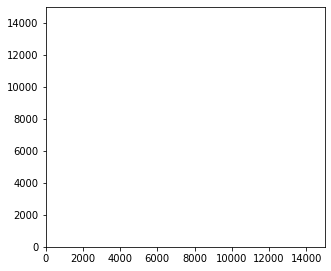

In [98]:
# dense model
wide_window.plot_map2(dense,input_width=1,plot_col=["playerx","playery"])

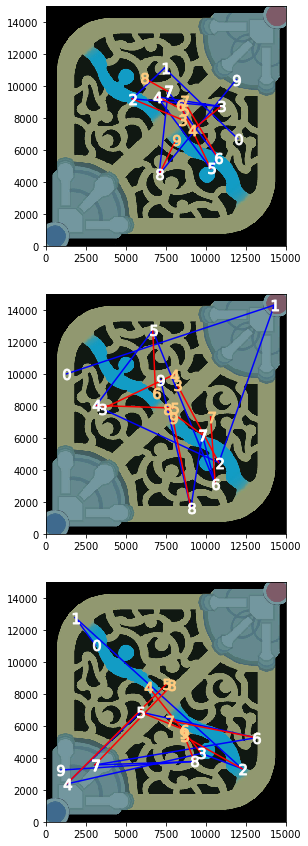

In [51]:
# lookback of 3
wide_window.plot_map2(conv_models[3],input_width=3,plot_col=["playerx","playery"])

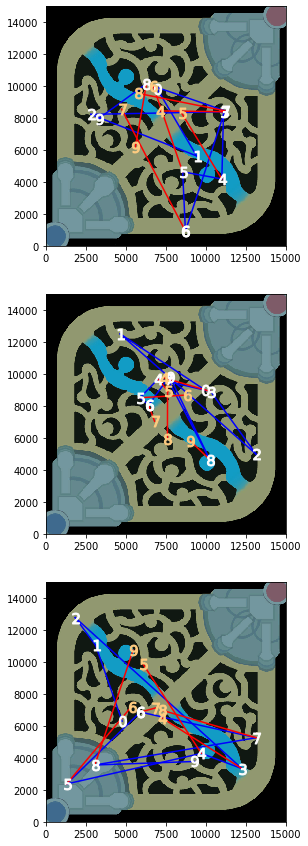

In [52]:
# lookback of 4
wide_window.plot_map2(conv_models[4],input_width=4,plot_col=["playerx","playery"])

In [ ]:
# lookback of 2
wide_window.plot_map2(conv_models[2],input_width=2,plot_col=["playerx","playery"])

In [47]:
# a small look at what a model is doing - I'd like to look more into this
import keras

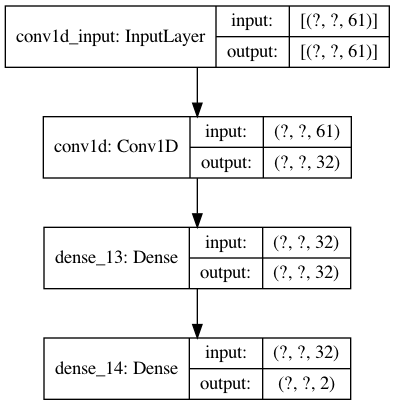

In [49]:
keras.utils.plot_model(conv_models[2], "images/dense_model.png", show_shapes=True)